### dataset - best-artworks-of-all-time(kaggle) for styles &  Pascal VOC (tensorflow) for content images

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ikarus777/best-artworks-of-all-time")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/best-artworks-of-all-time


In [2]:
base="/kaggle/input/best-artworks-of-all-time"

In [2]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import zipfile 


IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 100
AUTOTUNE = tf.data.AUTOTUNE

2025-11-26 16:03:04.317033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764172984.490726      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764172984.539600      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Dataset

In [5]:
def decode_and_resize(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def extract_image_from_voc(element):
    image = element["image"]
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


style_images=os.listdir(f"{base}/resized/resized")
style_images=[os.path.join(f"{base}/resized/resized/{i}") for i in style_images]

total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)]
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)]
test_style = style_images[int(0.9 * total_style_images) :]

In [6]:
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

I0000 00:00:1764091013.136542      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
train_content_ds = tfds.load("voc", split="train").map(extract_image_from_voc).repeat()
val_content_ds = (tfds.load("voc", split="validation").map(extract_image_from_voc).repeat())
test_content_ds = (tfds.load("voc", split="test").map(extract_image_from_voc, num_parallel_calls=AUTOTUNE).repeat())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.R4ALLY_5.0.0/voc-test.tfrecord*...:   0%|          | 0…

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.R4ALLY_5.0.0/voc-train.tfrecord*...:   0%|          | …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.R4ALLY_5.0.0/voc-validation.tfrecord*...:   0%|       …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/5.0.0. Subsequent calls will reuse this data.


In [10]:
# the size of train_style_ds and train_content_ds is not same so min length will be taken
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Visualisation

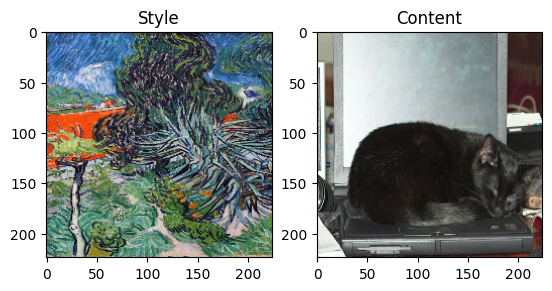

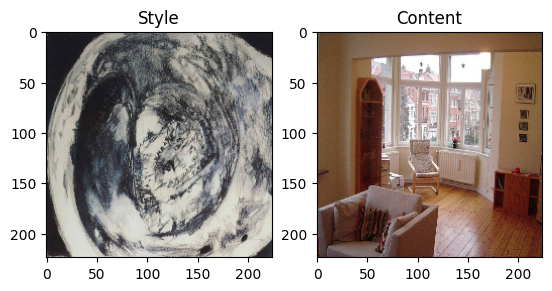

In [11]:
style,content=next(iter(train_ds))[:2]

# style and content will be a batch of 64 images
for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(style[i])
    plt.title("Style")

    plt.subplot(1,2,2)
    plt.imshow(content[i])
    plt.title("Content")
    plt.show()

# Model

## Encoder

In [12]:
def get_encoder():
    vgg19=keras.applications.VGG19(
        include_top=False,
        input_shape=(*IMAGE_SIZE,3),
        weights="imagenet"
    )

    vgg19.trainable=False
    mid_model=keras.Model(vgg19.input,vgg19.get_layer('block4_conv1').output)

    inputs=tf.keras.layers.Input([*IMAGE_SIZE,3])
    output=mid_model(inputs)
    return tf.keras.Model(inputs,output)

## Adaptive Instance Normalization

In [40]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation

def ada_in(style,content):
    mean_style,std_style=get_mean_std(style)
    mean_content,std_content=get_mean_std(content)

    return std_style*(content-mean_content)/std_content+mean_style

## Decoder

In [14]:
def get_decoder():
    config={"kernel_size":3,"strides":1,"padding":"same","activation":"relu"}
    return tf.keras.Sequential([
        tf.keras.layers.Input((None,None,512)),
        tf.keras.layers.Conv2D(512,**config),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(256,**config),
        tf.keras.layers.Conv2D(256,**config),
        tf.keras.layers.Conv2D(256,**config),
        tf.keras.layers.Conv2D(256,**config),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128,**config),
        tf.keras.layers.Conv2D(128,**config),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(64,**config),
        tf.keras.layers.Conv2D(3,kernel_size=3,strides=1,padding="same",activation="sigmoid"),
    ])

# Loss function

In [15]:
def get_loss_net():
    vgg19=keras.applications.VGG19(weights="imagenet",include_top=False,input_shape=(*IMAGE_SIZE,3))
    vgg19.trainable=False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = tf.keras.Model(vgg19.input, outputs)

    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="loss_net")

## Neural Style Transfer

**I am using custom class because by that we can customize what will happen in model.fit**

In [16]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self,encoder,decoder,loss_net,style_weight,**kwargs):
        super().__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder
        self.loss_net = loss_net
        self.style_weight = style_weight
        self.alpha=1

    def compile(self,optimizer,loss_fn):
        super().compile()
        self.optimizer=optimizer
        self.loss_fn=loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self,inputs):
        style,content=inputs

        loss_style=0.0

        with tf.GradientTape() as tape:
            style_encoded=self.encoder(style)
            content_encoded=self.encoder(content)

            t=ada_in(style_encoded,content_encoded)
            
            t = self.alpha * t + (1 - self.alpha) * content_encoded
            out=self.decoder(t)

            style_vgg_features=self.loss_net(style)
            out_vgg_features=self.loss_net(out)

            content_loss=self.loss_fn(bot,out_vgg_features[-1])
            for inp,out in zip(style_vgg_features,out_vgg_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)
                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(std_inp, std_out)

            loss_style = self.style_weight * loss_style
            total_loss = content_loss + loss_style

        trainable_params=self.decoder.trainable_variables
        gradients=tape.gradient(total_loss,trainable_params)

        self.optimizer.apply_gradients(zip(gradients,trainable_params))

        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(content_loss)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        # Encode the style and content image.
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)

        # Compute the AdaIN target feature maps.
        t = ada_in(style=style_encoded, content=content_encoded)
        t = self.alpha * t + (1 - self.alpha) * content_encoded
        
        # Generate the neural style transferred image.
        reconstructed_image = self.decoder(t)

        # Compute the losses.
        recons_vgg_features = self.loss_net(reconstructed_image)
        style_vgg_features = self.loss_net(style)
        loss_content = self.loss_fn(t, recons_vgg_features[-1])
        for inp, out in zip(style_vgg_features, recons_vgg_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)
            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                std_inp, std_out
            )
        loss_style = self.style_weight * loss_style
        total_loss = loss_content + loss_style

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]

In [17]:
class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        # style and content are defined in visulaisation section
        style_encoded=self.model.encoder(style)
        content_encoded=self.model.encoder(content)

        bot=ada_in(style_encoded,content_encoded)

        out=self.model.decoder(bot)

        i=0
        plt.subplot(1,3,1)
        plt.imshow(style[i])
        plt.title("Style")

        plt.subplot(1,3,2)
        plt.imshow(content[i])
        plt.title("Content")

        plt.subplot(1,3,3)
        plt.imshow(out[i])
        plt.title("Content")

        plt.axis('off')
        plt.show()

# Training

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 146.4241 - style_loss: 434.2206 - total_loss: 580.6447

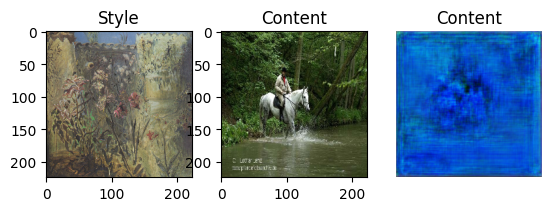

50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - content_loss: 146.3250 - style_loss: 433.4100 - total_loss: 579.7349 - val_content_loss: 134.6126 - val_style_loss: 333.4039 - val_total_loss: 468.0165
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 132.3228 - style_loss: 315.8581 - total_loss: 448.1809

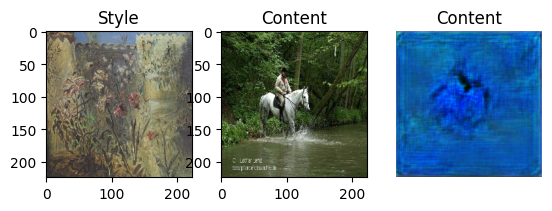

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 132.2837 - style_loss: 315.4986 - total_loss: 447.7823 - val_content_loss: 125.4012 - val_style_loss: 261.6621 - val_total_loss: 387.0632
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - content_loss: 121.6759 - style_loss: 239.6412 - total_loss: 361.3171

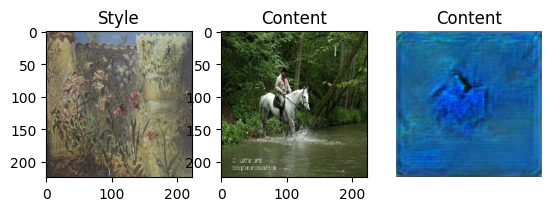

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 121.6676 - style_loss: 239.5018 - total_loss: 361.1694 - val_content_loss: 118.2019 - val_style_loss: 214.1747 - val_total_loss: 332.3766
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 117.1628 - style_loss: 207.8763 - total_loss: 325.0391

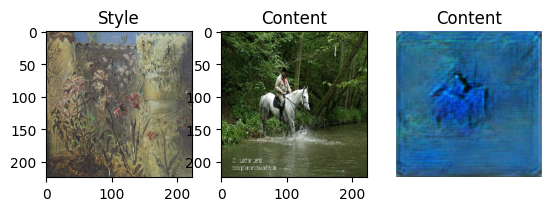

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 117.1394 - style_loss: 207.7292 - total_loss: 324.8686 - val_content_loss: 113.3017 - val_style_loss: 185.2746 - val_total_loss: 298.5762
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 110.1681 - style_loss: 177.4791 - total_loss: 287.6473

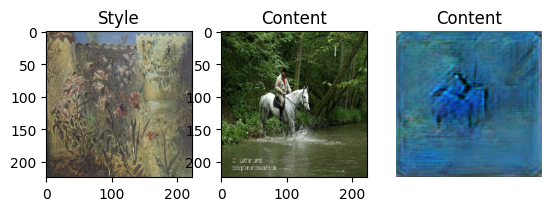

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 110.1523 - style_loss: 177.4037 - total_loss: 287.5559 - val_content_loss: 107.3983 - val_style_loss: 165.2910 - val_total_loss: 272.6893
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - content_loss: 106.8704 - style_loss: 160.2947 - total_loss: 267.1651

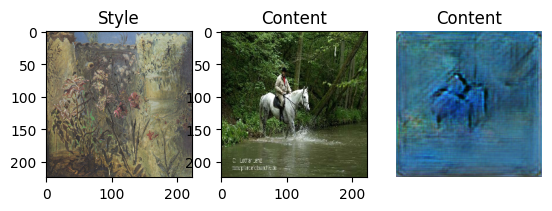

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 106.8489 - style_loss: 160.2127 - total_loss: 267.0616 - val_content_loss: 102.7173 - val_style_loss: 147.7717 - val_total_loss: 250.4890
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 102.6084 - style_loss: 142.4689 - total_loss: 245.0773

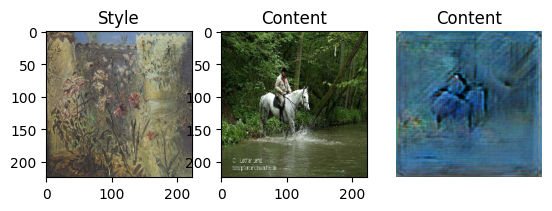

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 102.5667 - style_loss: 142.3486 - total_loss: 244.9153 - val_content_loss: 98.7938 - val_style_loss: 132.0517 - val_total_loss: 230.8455
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 99.2720 - style_loss: 128.4956 - total_loss: 227.7676

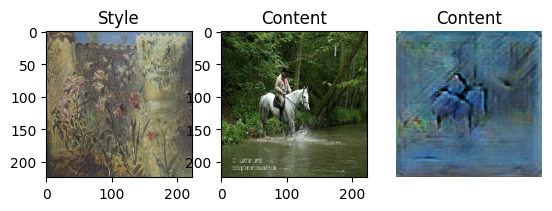

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 99.2413 - style_loss: 128.4197 - total_loss: 227.6611 - val_content_loss: 95.4937 - val_style_loss: 118.5821 - val_total_loss: 214.0758
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - content_loss: 94.9249 - style_loss: 114.5970 - total_loss: 209.5219

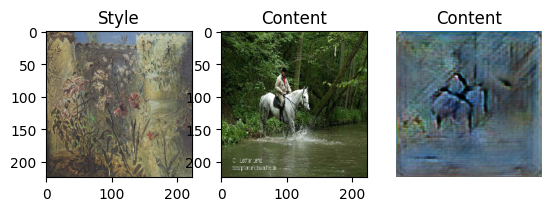

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 94.8953 - style_loss: 114.5399 - total_loss: 209.4352 - val_content_loss: 92.2569 - val_style_loss: 108.1131 - val_total_loss: 200.3700
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - content_loss: 92.1145 - style_loss: 104.8999 - total_loss: 197.0144

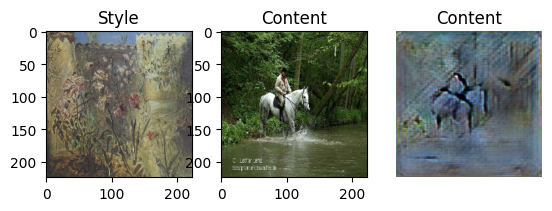

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 92.1077 - style_loss: 104.8750 - total_loss: 196.9828 - val_content_loss: 89.6464 - val_style_loss: 99.1421 - val_total_loss: 188.7885
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 88.5847 - style_loss: 95.0374 - total_loss: 183.6220

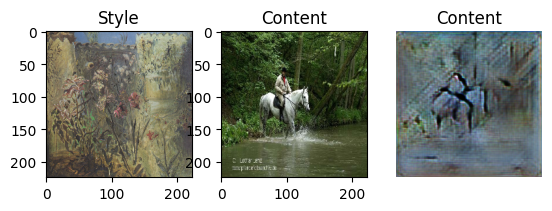

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 88.5674 - style_loss: 94.9954 - total_loss: 183.5628 - val_content_loss: 87.9135 - val_style_loss: 91.6180 - val_total_loss: 179.5314
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 87.3536 - style_loss: 91.0554 - total_loss: 178.4090

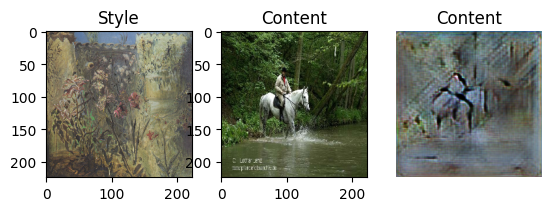

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 87.3433 - style_loss: 91.0279 - total_loss: 178.3712 - val_content_loss: 85.8507 - val_style_loss: 85.9198 - val_total_loss: 171.7704
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 85.5102 - style_loss: 84.4560 - total_loss: 169.9662

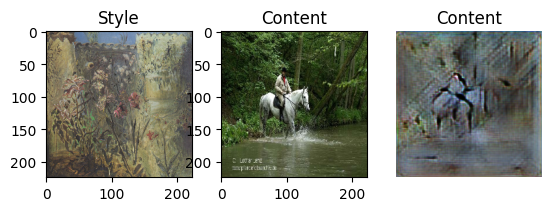

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 85.4917 - style_loss: 84.4270 - total_loss: 169.9186 - val_content_loss: 82.8965 - val_style_loss: 82.7569 - val_total_loss: 165.6534
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 82.6919 - style_loss: 78.9990 - total_loss: 161.6910

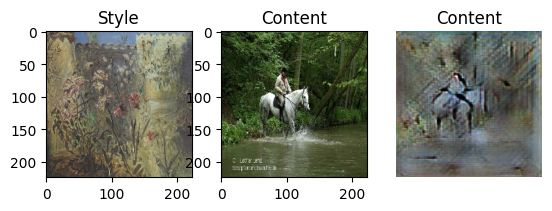

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 82.6943 - style_loss: 79.0075 - total_loss: 161.7018 - val_content_loss: 81.3448 - val_style_loss: 78.5877 - val_total_loss: 159.9325
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 82.0006 - style_loss: 77.3818 - total_loss: 159.3824

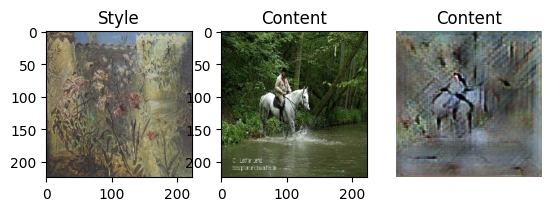

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 81.9949 - style_loss: 77.3757 - total_loss: 159.3707 - val_content_loss: 81.0271 - val_style_loss: 74.9422 - val_total_loss: 155.9693
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 79.1105 - style_loss: 71.8088 - total_loss: 150.9194

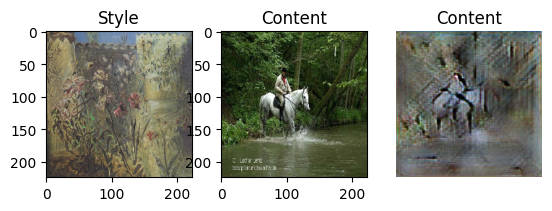

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 79.1141 - style_loss: 71.8258 - total_loss: 150.9400 - val_content_loss: 79.0906 - val_style_loss: 71.8833 - val_total_loss: 150.9738
Epoch 17/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 79.1514 - style_loss: 72.3250 - total_loss: 151.4764

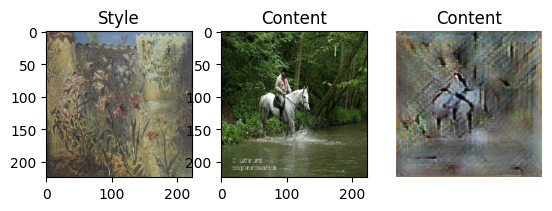

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 79.1455 - style_loss: 72.3089 - total_loss: 151.4544 - val_content_loss: 77.8853 - val_style_loss: 69.2007 - val_total_loss: 147.0860
Epoch 18/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 76.6200 - style_loss: 67.9531 - total_loss: 144.5731

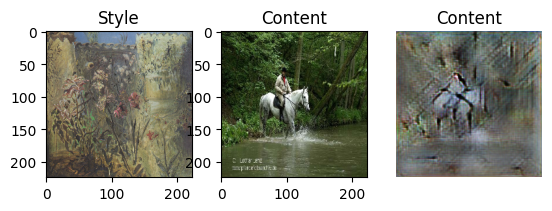

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 76.6225 - style_loss: 67.9447 - total_loss: 144.5672 - val_content_loss: 76.0358 - val_style_loss: 67.7075 - val_total_loss: 143.7433
Epoch 19/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 76.4815 - style_loss: 67.0525 - total_loss: 143.5340

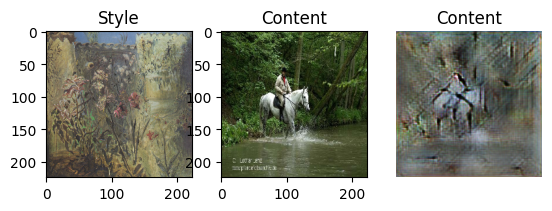

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 76.4755 - style_loss: 67.0415 - total_loss: 143.5170 - val_content_loss: 75.2682 - val_style_loss: 65.0878 - val_total_loss: 140.3560
Epoch 20/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 75.6282 - style_loss: 65.1071 - total_loss: 140.7353

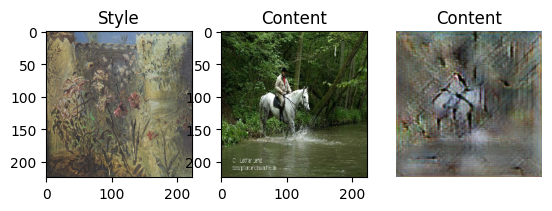

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 75.6050 - style_loss: 65.0794 - total_loss: 140.6844 - val_content_loss: 74.0436 - val_style_loss: 63.8943 - val_total_loss: 137.9380
Epoch 21/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 74.7918 - style_loss: 63.1208 - total_loss: 137.9127

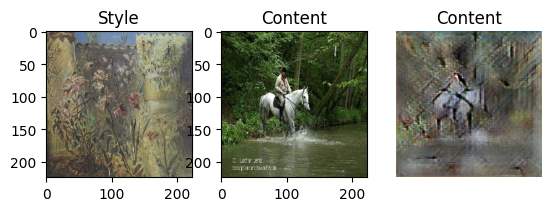

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 74.7824 - style_loss: 63.1181 - total_loss: 137.9005 - val_content_loss: 73.1143 - val_style_loss: 61.5981 - val_total_loss: 134.7123
Epoch 22/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 72.1564 - style_loss: 59.6993 - total_loss: 131.8556

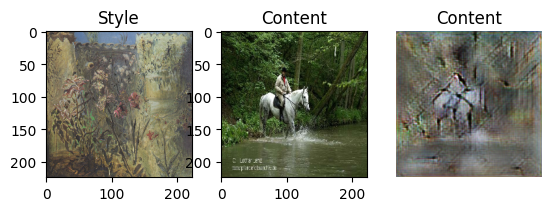

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 72.1571 - style_loss: 59.7026 - total_loss: 131.8597 - val_content_loss: 71.9986 - val_style_loss: 60.5536 - val_total_loss: 132.5522
Epoch 23/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - content_loss: 72.3515 - style_loss: 59.7045 - total_loss: 132.0561

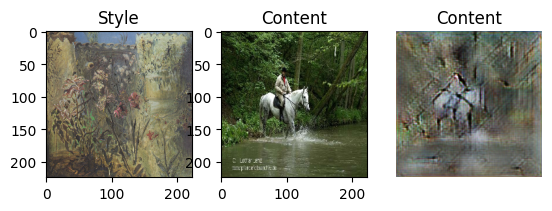

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 72.3501 - style_loss: 59.7168 - total_loss: 132.0670 - val_content_loss: 70.7387 - val_style_loss: 59.7237 - val_total_loss: 130.4623
Epoch 24/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 70.8258 - style_loss: 57.5691 - total_loss: 128.3950

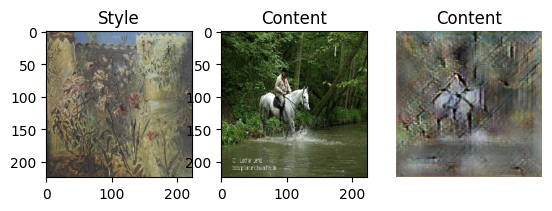

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 70.8200 - style_loss: 57.5547 - total_loss: 128.3747 - val_content_loss: 70.0633 - val_style_loss: 57.7932 - val_total_loss: 127.8566
Epoch 25/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - content_loss: 69.9053 - style_loss: 56.8327 - total_loss: 126.7380

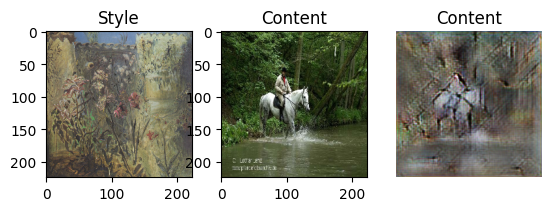

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 69.9096 - style_loss: 56.8426 - total_loss: 126.7522 - val_content_loss: 68.3613 - val_style_loss: 58.3949 - val_total_loss: 126.7562
Epoch 26/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 70.0124 - style_loss: 56.2488 - total_loss: 126.2611

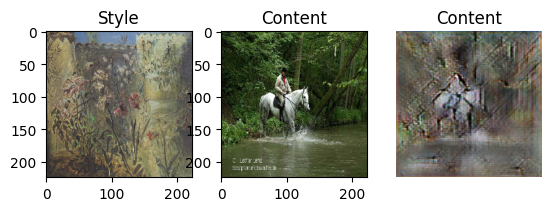

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 69.9949 - style_loss: 56.2248 - total_loss: 126.2197 - val_content_loss: 68.5545 - val_style_loss: 55.6719 - val_total_loss: 124.2264
Epoch 27/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 68.4442 - style_loss: 54.9798 - total_loss: 123.4240

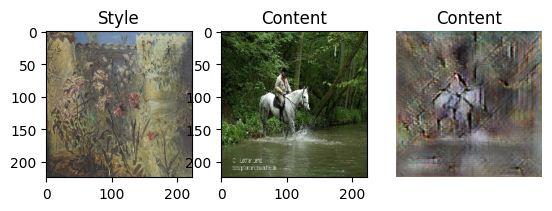

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 68.4489 - style_loss: 54.9815 - total_loss: 123.4304 - val_content_loss: 68.2022 - val_style_loss: 54.5075 - val_total_loss: 122.7096
Epoch 28/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - content_loss: 68.5010 - style_loss: 55.8510 - total_loss: 124.3520

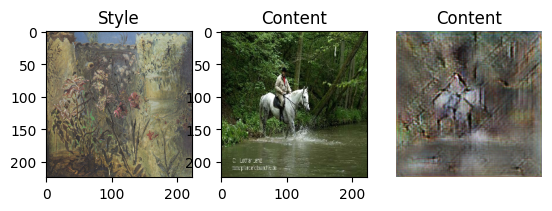

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 68.4899 - style_loss: 55.8184 - total_loss: 124.3083 - val_content_loss: 66.3015 - val_style_loss: 55.4707 - val_total_loss: 121.7722
Epoch 29/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - content_loss: 66.4193 - style_loss: 51.9586 - total_loss: 118.3779

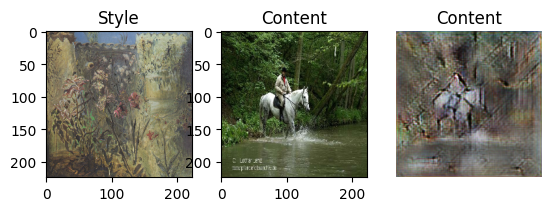

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 66.4246 - style_loss: 51.9577 - total_loss: 118.3823 - val_content_loss: 67.5057 - val_style_loss: 52.4233 - val_total_loss: 119.9290
Epoch 30/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 67.3896 - style_loss: 53.2231 - total_loss: 120.6126

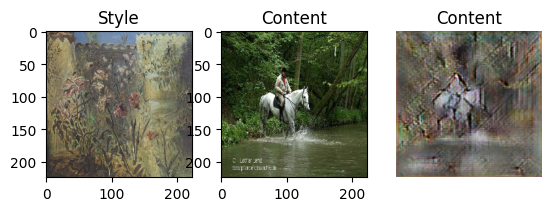

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 67.3802 - style_loss: 53.2054 - total_loss: 120.5856 - val_content_loss: 66.5256 - val_style_loss: 51.9292 - val_total_loss: 118.4548
Epoch 31/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 65.6252 - style_loss: 51.4284 - total_loss: 117.0535

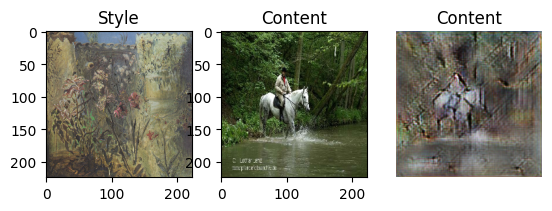

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 65.6230 - style_loss: 51.4217 - total_loss: 117.0447 - val_content_loss: 65.8569 - val_style_loss: 50.9321 - val_total_loss: 116.7891
Epoch 32/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 66.2344 - style_loss: 51.5143 - total_loss: 117.7487

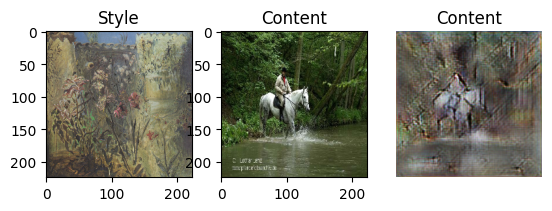

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 66.2214 - style_loss: 51.5029 - total_loss: 117.7243 - val_content_loss: 64.7351 - val_style_loss: 50.8343 - val_total_loss: 115.5694
Epoch 33/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 65.3919 - style_loss: 50.2911 - total_loss: 115.6830

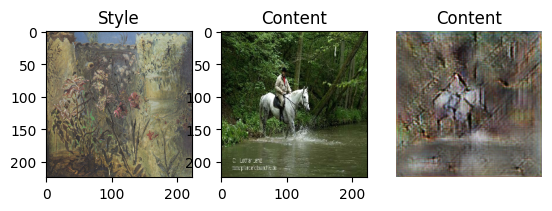

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 65.3750 - style_loss: 50.2659 - total_loss: 115.6410 - val_content_loss: 64.8803 - val_style_loss: 49.4057 - val_total_loss: 114.2861
Epoch 34/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 66.0575 - style_loss: 51.4627 - total_loss: 117.5202

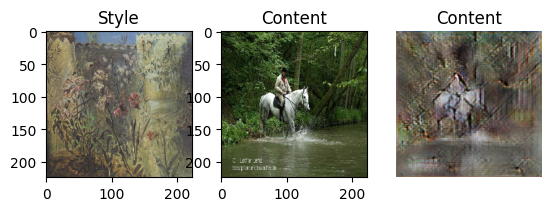

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 66.0396 - style_loss: 51.4488 - total_loss: 117.4885 - val_content_loss: 63.4980 - val_style_loss: 49.8954 - val_total_loss: 113.3935
Epoch 35/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - content_loss: 63.5662 - style_loss: 48.0017 - total_loss: 111.5679

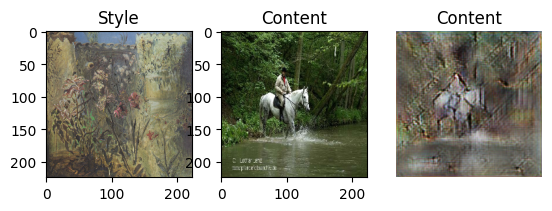

50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - content_loss: 63.5610 - style_loss: 47.9950 - total_loss: 111.5560 - val_content_loss: 63.5121 - val_style_loss: 48.8742 - val_total_loss: 112.3863
Epoch 36/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - content_loss: 63.7677 - style_loss: 48.6619 - total_loss: 112.4297

KeyboardInterrupt: 

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
decoder = get_decoder()

model_checkpoint=tf.keras.callbacks.ModelCheckpoint('model.keras',monitor='val_loss',verbose=1,save_best_only=True)

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=10.0
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)


In [ ]:
# voc dataset has 2,500 train and val images
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=50,
    validation_data=val_ds,
    validation_steps=50,
    callbacks=[TrainMonitor(),model_checkpoint],
)

In [20]:
# code for checing ouput
style,content=next(iter(test_ds))[:5]
def check_model(model):
      style_encoded=model.encoder(style)
      content_encoded=model.encoder(content)

      bot=ada_in(style_encoded,content_encoded)

      out=model.decoder(bot)

      for i in range(5):
        plt.subplot(1,3,1)
        plt.imshow(style[i])
        plt.title("Style")

        plt.subplot(1,3,2)
        plt.imshow(content[i])
        plt.title("Content")

        plt.subplot(1,3,3)
        plt.imshow(out[i])
        plt.title("Content")

        plt.axis('off')
        plt.show()

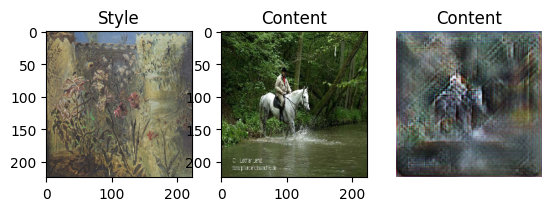

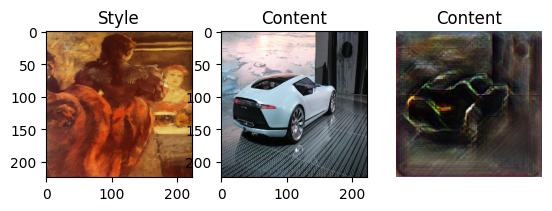

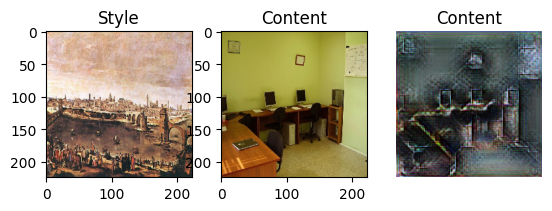

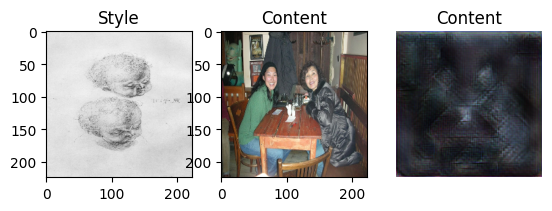

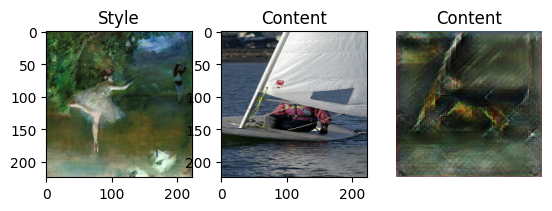

In [21]:
check_model(model)

In [ ]:
model.save("model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [ ]:
!pip install onnxruntime tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0d

In [ ]:
# converting model onnx
import onnxruntime as ort
import tensorflow as tf
import tf2onnx


spec = (tf.TensorSpec((1, *model.encoder.input_shape[1:]), tf.float32, name="input"),)
tf2onnx.convert.from_keras(model.encoder, input_signature=spec, opset=17,output_path="encoder.onnx")


inp = tf.keras.Input(shape=model.decoder.input_shape[1:], name="input")
out = model.decoder(inp)
wrapped_decoder = tf.keras.Model(inputs=inp, outputs=out)

spec = (tf.TensorSpec((1, *model.decoder.input_shape[1:]), tf.float32, name="input"),)
tf2onnx.convert.from_keras(wrapped_decoder, input_signature=spec, opset=17,output_path="decoder.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7a201c42d6c0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7a201c42d6c0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Buffered data was truncated after reaching the output size limit.

In [135]:
!pip install mlflow
!pip install mlflow[extras]
!pip install boto3
!pip install awscli
!aws configure

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 106.1 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.41.4
    Uninstalling botocore-1.41.4:
      Successfully uninstalled botocore-1.41.4
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.15.0
    Uninstalling s3transfer-0.15.0:
      Successfully uninstalled s3transfer-0.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.43.4 requires botocore==1.41.4, but you have botocore 1.40.76 which is incompatible.
awscli 1.43.4 requires s3transfer<0.16.0,>=0.15.0, but you have s3transfer 0.14.0 which is incompatible.
aiobotocore 2.25.1 requires botocore<1.40.62,>=1.40.46, but you have botocore 1.40.76 which is incompatible.
s3fs 2025.3.0 req

In [131]:
# logging model to mlflow

import mlflow

mlflow.set_tracking_uri("http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("NeuralStyleTransform")


<Experiment: artifact_location='s3://pankaj-maulekhi-mlflow/331043977459496726', creation_time=1764084914993, experiment_id='331043977459496726', last_update_time=1764084914993, lifecycle_stage='active', name='NeuralStyleTransform', tags={}>

In [4]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00


In [141]:
import onnx

encoder_path="/kaggle/working/encoder.onnx"
decoder_path="/kaggle/working/decoder.onnx"

encoder=onnx.load(encoder_path)
decoder=onnx.load(decoder_path)

import os

os.environ["AWS_ACCESS_KEY_ID"] = ""
os.environ["AWS_SECRET_ACCESS_KEY"] = ""
os.environ["AWS_DEFAULT_REGION"] = "eu-north-1"

# EPOCHS="pretrained"
# BATCH_SIZE="pretrained"
with mlflow.start_run():
    mlflow.onnx.log_model(encoder,artifact_path='encoder')
    mlflow.log_param("name","NSTencoder")
    mlflow.log_param("epochs",EPOCHS)
    mlflow.log_param("batch_size",BATCH_SIZE)

with mlflow.start_run():
    mlflow.onnx.log_model(decoder,artifact_path='decoder')
    mlflow.log_param("name","NSTdecoder")
    mlflow.log_param("epochs",EPOCHS)
    mlflow.log_param("batch_size",BATCH_SIZE)

2025/11/26 18:24:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/26 18:24:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run burly-grouse-428 at: http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000/#/experiments/331043977459496726/runs/0179cde372fb4f60bfb93deb104e682f
🧪 View experiment at: http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000/#/experiments/331043977459496726


2025/11/26 18:24:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/26 18:24:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run omniscient-midge-229 at: http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000/#/experiments/331043977459496726/runs/d0c790f0a1fe43fa9218e6b238a1d930
🧪 View experiment at: http://ec2-13-51-234-7.eu-north-1.compute.amazonaws.com:5000/#/experiments/331043977459496726


In [142]:
run_id="0179cde372fb4f60bfb93deb104e682f"
encoder_uri = f"runs:/{run_id}/encoder"
encoder_name = "NSTencoder"
model_version = mlflow.register_model(encoder_uri, encoder_name)

Registered model 'NSTencoder' already exists. Creating a new version of this model...
2025/11/26 18:25:55 WARNING mlflow.tracking._model_registry.fluent: Run with id 0179cde372fb4f60bfb93deb104e682f has no artifacts at artifact path 'encoder', registering model based on models:/m-ff8708057865403293c3b4a7c07aef87 instead
2025/11/26 18:25:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: NSTencoder, version 2
Created version '2' of model 'NSTencoder'.


In [143]:
# registering model
run_id="d0c790f0a1fe43fa9218e6b238a1d930"
decoder_uri = f"runs:/{run_id}/decoder"
decoder_name = "NSTdecoder"
model_version = mlflow.register_model(decoder_uri, decoder_name)

Registered model 'NSTdecoder' already exists. Creating a new version of this model...
2025/11/26 18:26:19 WARNING mlflow.tracking._model_registry.fluent: Run with id d0c790f0a1fe43fa9218e6b238a1d930 has no artifacts at artifact path 'decoder', registering model based on models:/m-091e9802e0db4fa79fbab389c659538e instead
2025/11/26 18:26:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: NSTdecoder, version 2
Created version '2' of model 'NSTdecoder'.


In [29]:
encoder_local_path=mlflow.artifacts.download_artifacts(encoder_uri)
decoder_local_path=mlflow.artifacts.download_artifacts(decoder_uri)

In [36]:
# checking model
import onnxruntime as ort
encoder=ort.InferenceSession(
    encoder_local_path+'model.onnx',
    providers=["CUDAExecutionProvider"]   # GPU
)
decoder=ort.InferenceSession(
    decoder_local_path+'model.onnx',
    providers=["CUDAExecutionProvider"]   # GPU
)

In [73]:
import cv2
style=[np.array(Image.open("/download (5).jpeg"))/255.0]
content=[np.array(Image.open("/download.png"))/255.0]

style=[cv2.resize(i,(224,224)) for i in style]
content=[cv2.resize(i,(224,224)) for i in content]

In [74]:
def check_model(encoder,decoder):
      # get input and ouput names
      input_name_encoder = encoder.get_inputs()[0].name
      output_name_encoder = encoder.get_outputs()[0].name

      input_name_decoder = decoder.get_inputs()[0].name
      output_name_decoder = decoder.get_outputs()[0].name

      for i in range(1):
        style_encoded=encoder.run([output_name_encoder],{input_name_encoder:np.expand_dims(np.array(style[i]),axis=0).astype(np.float32)})[0][0]
        content_encoded=encoder.run([output_name_encoder],{input_name_encoder:np.expand_dims(np.array(content[i]),axis=0).astype(np.float32)})[0][0]

        bot=ada_in(style_encoded,content_encoded)

        out=decoder.run([output_name_decoder],{input_name_decoder:np.expand_dims(np.array(bot),axis=0).astype(np.float32)})[0]

        plt.subplot(1,3,1)
        plt.imshow(style[i])
        plt.title("Style")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(content[i])
        plt.title("Content")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(out[0])
        plt.title("Content")

        plt.axis('off')
        plt.show()

In [ ]:
check_model(encoder,decoder)

In [77]:
keras_encoder=tf.keras.models.load_model("/encoder (1).keras")
keras_decoder=tf.keras.models.load_model("/decoder (1).keras")

# Final model

In [ ]:
#  i am using pretrained model because pretrained models are trained on much larger dataset and for much larger time so they give much better result

In [2]:
# this code is fromt his repo https://github.com/naoto0804/pytorch-AdaIN  it is required for loading models
import torch.nn as nn


decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

In [51]:
import torch

vgg.load_state_dict(torch.load("/kaggle/input/adinn-pretrained/vgg_normalised.pth"))
decoder.load_state_dict(torch.load("/kaggle/input/adinn-pretrained/decoder.pth"))

<All keys matched successfully>

In [52]:
import torch.nn as nn
enc_layers = list(vgg.children())

enc_1 = nn.Sequential(*enc_layers[:4])
enc_2 = nn.Sequential(*enc_layers[4:11])
enc_3 = nn.Sequential(*enc_layers[11:18])
enc_4 = nn.Sequential(*enc_layers[18:31])  # relu4_1

In [53]:
encoder = nn.Sequential(enc_1, enc_2, enc_3, enc_4).eval()

In [54]:
torch.onnx.export(
    encoder,
    torch.randn(1, 3, 256, 256),
    "encoder.onnx",
    input_names=["input"],
    output_names=["relu4_1"],
    opset_version=17,
    dynamic_axes={
        "input": {2: "h", 3: "w"},
        "relu4_1": {2: "h_out", 3: "w_out"},
    },
)

/usr/local/lib/python3.11/dist-packages/torch/onnx/_internal/jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.11/dist-packages/torch/onnx/utils.py:657: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/usr/local/lib/python3.11/dist-packages/torch/onnx/utils.py:1127: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_on

In [55]:
torch.onnx.export(
    decoder,
    torch.randn(1, 512, 32, 32),   # dummy only for tracing
    "decoder.onnx",
    input_names=["features"],
    output_names=["output"],
    opset_version=17,
    dynamic_axes={
        "features": {2: "h_in", 3: "w_in"},
        "output": {2: "h_out", 3: "w_out"},
    },
)


In [56]:
# !pip install onnxruntime

In [57]:
import onnxruntime as ort
import numpy as np

enc_sess = ort.InferenceSession("/kaggle/working/encoder.onnx")
dec_sess = ort.InferenceSession("/kaggle/working/decoder.onnx")


In [90]:
import numpy as np

def prepare(img):
    # img shape: (H, W, 3), dtype=uint8
    img = img.astype(np.float32)
    img = img.transpose(2, 0, 1)       # HWC → CHW
    img = np.expand_dims(img, axis=0)  # CHW → NCHW
    return img

In [122]:
from PIL import Image
import cv2

style=np.array(Image.open("/kaggle/input/adinn-pretrained/sketch.png"))
style=prepare(cv2.resize(style,(512,512)))

content=np.array(Image.open("/kaggle/input/adinn-pretrained/sailboat.jpg"))
content=prepare(cv2.resize(content,(512,512)))

In [123]:
c_feat = enc_sess.run(["relu4_1"], {"input": content})[0]
s_feat = enc_sess.run(["relu4_1"], {"input": style})[0]

In [124]:
def get_mean_std(x, epsilon=1e-5):
    axes = (2, 3)
    mean, variance = np.mean(x, axis=axes,keepdims=True), np.var(x, axis=axes, keepdims=True)
    standard_deviation = np.sqrt(variance + epsilon)
    return mean, standard_deviation

def ada_in(style,content):
    mean_style,std_style=get_mean_std(style)
    mean_content,std_content=get_mean_std(content)

    return std_style*(content-mean_content)/std_content+mean_style
    
t = ada_in(s_feat,c_feat).astype(np.float32)

In [125]:
output = dec_sess.run(["output"], {"features": t})[0]


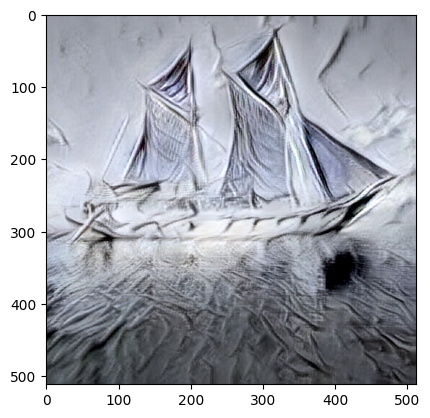

In [126]:
import matplotlib.pyplot as plt
img = output[0].transpose(1, 2, 0)        # (3,512,512) → (512,512,3)
img = np.clip(img, 0, 255).astype(np.uint8)
plt.imshow(img )
# img.shape